In [1]:
import argparse
import logging
import os
import sys
import itertools
from itertools import accumulate
from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torch_data
import torch.optim as optim
import matplotlib.pyplot as plt

sys.path.insert(0, "../src")
from collection import Collection

BASE_DIR = os.path.abspath('')

import torch.nn.functional as f


In [2]:
torch.manual_seed(1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [39]:
# Params
posting_length_to_use = 4096

scaling_factor=20

# Fix this
learning_rate = 1e-3
lambda_l2 = 1e-5


In [4]:
torch.set_default_tensor_type(torch.DoubleTensor)


In [5]:
def zigzag_encode (i):
    return (i >> 31) ^ (i << 1)

In [6]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        tensor.mul_(self.std).add_(self.mean)
        return tensor

In [7]:
class Dataset(torch_data.Dataset):
    def __init__(self, data_list, pos_list):
        self.data = data_list
        self.target = pos_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.target[index]



In [8]:
test_collection = Collection("../test_data/test_collection")
for term_id, pl in enumerate(test_collection):
    p = pl[0]
    for i in range(len(p)):
        print("{},{}".format(i,p[i]))
    sys.exit(0)

0,3
1,4
2,5
3,6
4,7
5,8
6,9
7,10
8,51
9,115
10,116
11,135
12,154
13,185
14,187
15,193
16,194
17,195
18,196
19,200
20,201
21,203
22,209
23,228
24,229
25,243
26,300
27,326
28,327
29,331
30,334
31,335
32,336
33,337
34,338
35,339
36,353
37,354
38,355
39,357
40,358
41,359
42,366
43,367
44,368
45,369
46,370
47,371
48,372
49,373
50,374
51,375
52,376
53,377
54,378
55,380
56,381
57,382
58,383
59,384
60,387
61,388
62,389
63,390
64,393
65,394
66,395
67,396
68,398
69,399
70,401
71,403
72,405
73,406
74,409
75,410
76,412
77,415
78,416
79,417
80,418
81,419
82,420
83,421
84,425
85,427
86,428
87,429
88,430
89,431
90,432
91,433
92,434
93,435
94,436
95,442
96,443
97,444
98,451
99,455
100,460
101,464
102,466
103,469
104,470
105,471
106,472
107,473
108,476
109,483
110,489
111,490
112,491
113,492
114,493
115,541
116,595
117,596
118,597
119,606
120,607
121,608
122,610
123,611
124,624
125,626
126,627
127,630
128,634
129,635
130,636
131,648
132,649
133,654
134,656
135,659
136,660
137,661
138,662
139,668
140,67

SystemExit: 0

/home/amallia/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


OrderedDict([('0.weight', tensor([[ 0.5910],
        [ 0.8274],
        [-0.4588]])), ('2.weight', tensor([[-0.5265,  0.0210,  0.3111]]))])
[TERM]: 4129, [TERM_LEN]: 5377, [EPOCH]: 0, [LOSS]: 2919.515625
[TERM]: 4129, [TERM_LEN]: 5377, [EPOCH]: 1000, [LOSS]: 2919.515625
[TERM]: 4129, [TERM_LEN]: 5377, [EPOCH]: 2000, [LOSS]: 2919.515625
[TERM]: 4129, [TERM_LEN]: 5377, [EPOCH]: 3000, [LOSS]: 2919.515625
[TERM]: 4129, [TERM_LEN]: 5377, [EPOCH]: 4000, [LOSS]: 2919.515625
[TERM]: 4129, [TERM_LEN]: 5377, [EPOCH]: 5000, [LOSS]: 2441.798827
[TERM]: 4129, [TERM_LEN]: 5377, [EPOCH]: 6000, [LOSS]: 2162.043775
[TERM]: 4129, [TERM_LEN]: 5377, [EPOCH]: 7000, [LOSS]: 1932.454852
[TERM]: 4129, [TERM_LEN]: 5377, [EPOCH]: 8000, [LOSS]: 1727.254826
[TERM]: 4129, [TERM_LEN]: 5377, [EPOCH]: 9000, [LOSS]: 1539.444699
[TERM]: 4129, [TERM_LEN]: 5377, [EPOCH]: 10000, [LOSS]: 1366.489022
[TERM]: 4129, [TERM_LEN]: 5377, [EPOCH]: 11000, [LOSS]: 1207.247938
[TERM]: 4129, [TERM_LEN]: 5377, [EPOCH]: 12000, [LOSS]: 1

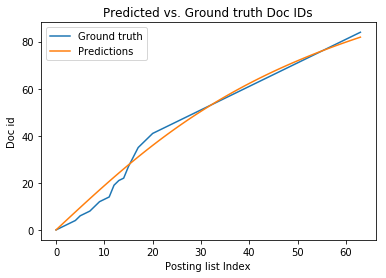

[TERM]: 4129, [TERM_LEN]: 5377, [EPOCH]: 100001, [LOSS]: 6.938157
[TERM]: 9072, [TERM_LEN]: 4955, [EPOCH]: 0, [LOSS]: 26.498610
[TERM]: 9072, [TERM_LEN]: 4955, [EPOCH]: 1000, [LOSS]: 11.963581
[TERM]: 9072, [TERM_LEN]: 4955, [EPOCH]: 2000, [LOSS]: 11.816154
[TERM]: 9072, [TERM_LEN]: 4955, [EPOCH]: 3000, [LOSS]: 11.637479
[TERM]: 9072, [TERM_LEN]: 4955, [EPOCH]: 4000, [LOSS]: 11.440565
[TERM]: 9072, [TERM_LEN]: 4955, [EPOCH]: 5000, [LOSS]: 11.225198
[TERM]: 9072, [TERM_LEN]: 4955, [EPOCH]: 6000, [LOSS]: 10.988934
[TERM]: 9072, [TERM_LEN]: 4955, [EPOCH]: 7000, [LOSS]: 10.728565
[TERM]: 9072, [TERM_LEN]: 4955, [EPOCH]: 8000, [LOSS]: 10.440188
[TERM]: 9072, [TERM_LEN]: 4955, [EPOCH]: 9000, [LOSS]: 10.118411
[TERM]: 9072, [TERM_LEN]: 4955, [EPOCH]: 10000, [LOSS]: 9.759286
[TERM]: 9072, [TERM_LEN]: 4955, [EPOCH]: 11000, [LOSS]: 9.354749
[TERM]: 9072, [TERM_LEN]: 4955, [EPOCH]: 12000, [LOSS]: 8.896221
[TERM]: 9072, [TERM_LEN]: 4955, [EPOCH]: 13000, [LOSS]: 8.375890
[TERM]: 9072, [TERM_LEN]: 4

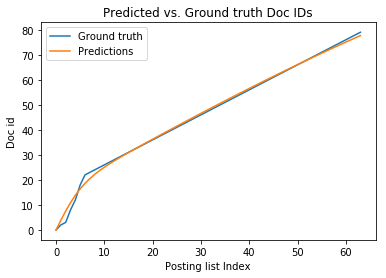

[TERM]: 9072, [TERM_LEN]: 4955, [EPOCH]: 100001, [LOSS]: 1.209817
[TERM]: 13974, [TERM_LEN]: 4648, [EPOCH]: 0, [LOSS]: 148.544302
[TERM]: 13974, [TERM_LEN]: 4648, [EPOCH]: 1000, [LOSS]: 14.858542
[TERM]: 13974, [TERM_LEN]: 4648, [EPOCH]: 2000, [LOSS]: 14.735705
[TERM]: 13974, [TERM_LEN]: 4648, [EPOCH]: 3000, [LOSS]: 14.545379
[TERM]: 13974, [TERM_LEN]: 4648, [EPOCH]: 4000, [LOSS]: 14.297466
[TERM]: 13974, [TERM_LEN]: 4648, [EPOCH]: 5000, [LOSS]: 14.028936
[TERM]: 13974, [TERM_LEN]: 4648, [EPOCH]: 6000, [LOSS]: 13.762067
[TERM]: 13974, [TERM_LEN]: 4648, [EPOCH]: 7000, [LOSS]: 13.505875
[TERM]: 13974, [TERM_LEN]: 4648, [EPOCH]: 8000, [LOSS]: 13.262627
[TERM]: 13974, [TERM_LEN]: 4648, [EPOCH]: 9000, [LOSS]: 13.033045
[TERM]: 13974, [TERM_LEN]: 4648, [EPOCH]: 10000, [LOSS]: 12.817012
[TERM]: 13974, [TERM_LEN]: 4648, [EPOCH]: 11000, [LOSS]: 12.614355
[TERM]: 13974, [TERM_LEN]: 4648, [EPOCH]: 12000, [LOSS]: 12.440008
[TERM]: 13974, [TERM_LEN]: 4648, [EPOCH]: 13000, [LOSS]: 12.249277
[TERM]: 

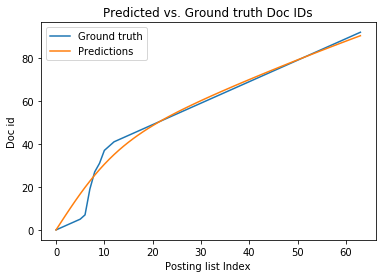

[TERM]: 13974, [TERM_LEN]: 4648, [EPOCH]: 100001, [LOSS]: 11.112563
[TERM]: 17496, [TERM_LEN]: 4313, [EPOCH]: 0, [LOSS]: 7.673709
[TERM]: 17496, [TERM_LEN]: 4313, [EPOCH]: 1000, [LOSS]: 2.359134
[TERM]: 17496, [TERM_LEN]: 4313, [EPOCH]: 2000, [LOSS]: 2.225238
[TERM]: 17496, [TERM_LEN]: 4313, [EPOCH]: 3000, [LOSS]: 2.145273
[TERM]: 17496, [TERM_LEN]: 4313, [EPOCH]: 4000, [LOSS]: 2.106478
[TERM]: 17496, [TERM_LEN]: 4313, [EPOCH]: 5000, [LOSS]: 2.089668
[TERM]: 17496, [TERM_LEN]: 4313, [EPOCH]: 6000, [LOSS]: 2.082974
[TERM]: 17496, [TERM_LEN]: 4313, [EPOCH]: 7000, [LOSS]: 2.080216
[TERM]: 17496, [TERM_LEN]: 4313, [EPOCH]: 8000, [LOSS]: 2.078839
[TERM]: 17496, [TERM_LEN]: 4313, [EPOCH]: 9000, [LOSS]: 2.385372
[TERM]: 17496, [TERM_LEN]: 4313, [EPOCH]: 10000, [LOSS]: 2.077236
[TERM]: 17496, [TERM_LEN]: 4313, [EPOCH]: 11000, [LOSS]: 2.076429
[TERM]: 17496, [TERM_LEN]: 4313, [EPOCH]: 12000, [LOSS]: 2.075718
[TERM]: 17496, [TERM_LEN]: 4313, [EPOCH]: 13000, [LOSS]: 2.075015
[TERM]: 17496, [TERM_

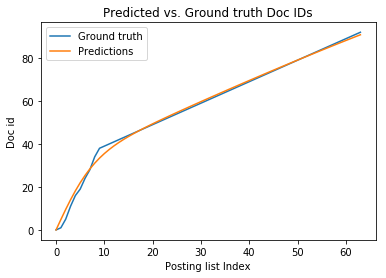

[TERM]: 17496, [TERM_LEN]: 4313, [EPOCH]: 100001, [LOSS]: 2.031009
[TERM]: 21277, [TERM_LEN]: 4326, [EPOCH]: 0, [LOSS]: 16.300034
[TERM]: 21277, [TERM_LEN]: 4326, [EPOCH]: 1000, [LOSS]: 9.246458
[TERM]: 21277, [TERM_LEN]: 4326, [EPOCH]: 2000, [LOSS]: 9.107971
[TERM]: 21277, [TERM_LEN]: 4326, [EPOCH]: 3000, [LOSS]: 8.923285
[TERM]: 21277, [TERM_LEN]: 4326, [EPOCH]: 4000, [LOSS]: 8.782952
[TERM]: 21277, [TERM_LEN]: 4326, [EPOCH]: 5000, [LOSS]: 8.709705
[TERM]: 21277, [TERM_LEN]: 4326, [EPOCH]: 6000, [LOSS]: 8.656554
[TERM]: 21277, [TERM_LEN]: 4326, [EPOCH]: 7000, [LOSS]: 8.752340
[TERM]: 21277, [TERM_LEN]: 4326, [EPOCH]: 8000, [LOSS]: 8.629077
[TERM]: 21277, [TERM_LEN]: 4326, [EPOCH]: 9000, [LOSS]: 8.621593
[TERM]: 21277, [TERM_LEN]: 4326, [EPOCH]: 10000, [LOSS]: 8.619469
[TERM]: 21277, [TERM_LEN]: 4326, [EPOCH]: 11000, [LOSS]: 8.618311
[TERM]: 21277, [TERM_LEN]: 4326, [EPOCH]: 12000, [LOSS]: 8.617543
[TERM]: 21277, [TERM_LEN]: 4326, [EPOCH]: 13000, [LOSS]: 8.616941
[TERM]: 21277, [TERM_

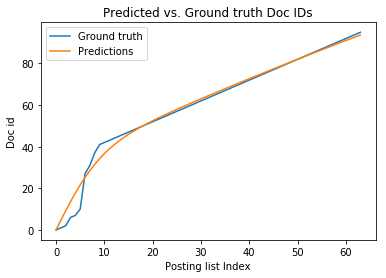

[TERM]: 21277, [TERM_LEN]: 4326, [EPOCH]: 100001, [LOSS]: 8.583558
[TERM]: 31550, [TERM_LEN]: 7614, [EPOCH]: 0, [LOSS]: 217.146338
[TERM]: 31550, [TERM_LEN]: 7614, [EPOCH]: 1000, [LOSS]: 12.350712
[TERM]: 31550, [TERM_LEN]: 7614, [EPOCH]: 2000, [LOSS]: 12.349570
[TERM]: 31550, [TERM_LEN]: 7614, [EPOCH]: 3000, [LOSS]: 11.936113
[TERM]: 31550, [TERM_LEN]: 7614, [EPOCH]: 4000, [LOSS]: 11.926392
[TERM]: 31550, [TERM_LEN]: 7614, [EPOCH]: 5000, [LOSS]: 11.956615
[TERM]: 31550, [TERM_LEN]: 7614, [EPOCH]: 6000, [LOSS]: 11.926422
[TERM]: 31550, [TERM_LEN]: 7614, [EPOCH]: 7000, [LOSS]: 11.926313
[TERM]: 31550, [TERM_LEN]: 7614, [EPOCH]: 8000, [LOSS]: 11.926307
[TERM]: 31550, [TERM_LEN]: 7614, [EPOCH]: 9000, [LOSS]: 11.926301
[TERM]: 31550, [TERM_LEN]: 7614, [EPOCH]: 10000, [LOSS]: 11.927154
[TERM]: 31550, [TERM_LEN]: 7614, [EPOCH]: 11000, [LOSS]: 11.926290
[TERM]: 31550, [TERM_LEN]: 7614, [EPOCH]: 12000, [LOSS]: 11.926284
[TERM]: 31550, [TERM_LEN]: 7614, [EPOCH]: 13000, [LOSS]: 11.926279
[TERM]:

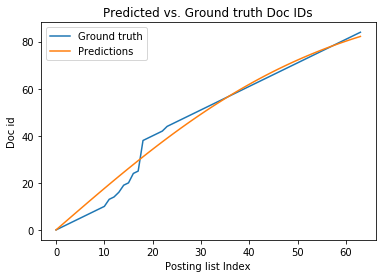

[TERM]: 31550, [TERM_LEN]: 7614, [EPOCH]: 100001, [LOSS]: 11.925813
[TERM]: 32990, [TERM_LEN]: 4238, [EPOCH]: 0, [LOSS]: 411.854644
[TERM]: 32990, [TERM_LEN]: 4238, [EPOCH]: 1000, [LOSS]: 283.538227
[TERM]: 32990, [TERM_LEN]: 4238, [EPOCH]: 2000, [LOSS]: 282.313246
[TERM]: 32990, [TERM_LEN]: 4238, [EPOCH]: 3000, [LOSS]: 281.151111
[TERM]: 32990, [TERM_LEN]: 4238, [EPOCH]: 4000, [LOSS]: 280.045854
[TERM]: 32990, [TERM_LEN]: 4238, [EPOCH]: 5000, [LOSS]: 278.991465
[TERM]: 32990, [TERM_LEN]: 4238, [EPOCH]: 6000, [LOSS]: 277.983949
[TERM]: 32990, [TERM_LEN]: 4238, [EPOCH]: 7000, [LOSS]: 277.021768
[TERM]: 32990, [TERM_LEN]: 4238, [EPOCH]: 8000, [LOSS]: 276.099499
[TERM]: 32990, [TERM_LEN]: 4238, [EPOCH]: 9000, [LOSS]: 275.215850
[TERM]: 32990, [TERM_LEN]: 4238, [EPOCH]: 10000, [LOSS]: 274.403955
[TERM]: 32990, [TERM_LEN]: 4238, [EPOCH]: 11000, [LOSS]: 273.559420
[TERM]: 32990, [TERM_LEN]: 4238, [EPOCH]: 12000, [LOSS]: 272.781819
[TERM]: 32990, [TERM_LEN]: 4238, [EPOCH]: 13000, [LOSS]: 272.

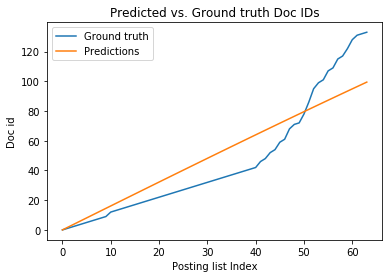

[TERM]: 32990, [TERM_LEN]: 4238, [EPOCH]: 100001, [LOSS]: 251.938218
[TERM]: 33596, [TERM_LEN]: 4987, [EPOCH]: 0, [LOSS]: 38.581454
[TERM]: 33596, [TERM_LEN]: 4987, [EPOCH]: 1000, [LOSS]: 13.868515
[TERM]: 33596, [TERM_LEN]: 4987, [EPOCH]: 2000, [LOSS]: 13.727417
[TERM]: 33596, [TERM_LEN]: 4987, [EPOCH]: 3000, [LOSS]: 13.701030
[TERM]: 33596, [TERM_LEN]: 4987, [EPOCH]: 4000, [LOSS]: 13.806488
[TERM]: 33596, [TERM_LEN]: 4987, [EPOCH]: 5000, [LOSS]: 13.700949
[TERM]: 33596, [TERM_LEN]: 4987, [EPOCH]: 6000, [LOSS]: 13.701539
[TERM]: 33596, [TERM_LEN]: 4987, [EPOCH]: 7000, [LOSS]: 13.702348
[TERM]: 33596, [TERM_LEN]: 4987, [EPOCH]: 8000, [LOSS]: 13.703332
[TERM]: 33596, [TERM_LEN]: 4987, [EPOCH]: 9000, [LOSS]: 13.701607
[TERM]: 33596, [TERM_LEN]: 4987, [EPOCH]: 10000, [LOSS]: 13.702845
[TERM]: 33596, [TERM_LEN]: 4987, [EPOCH]: 11000, [LOSS]: 13.731866
[TERM]: 33596, [TERM_LEN]: 4987, [EPOCH]: 12000, [LOSS]: 13.702368
[TERM]: 33596, [TERM_LEN]: 4987, [EPOCH]: 13000, [LOSS]: 13.703597
[TERM]

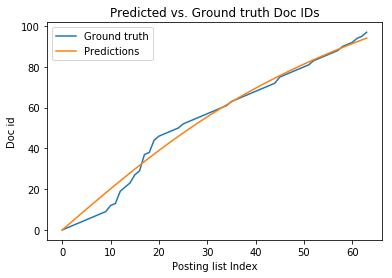

[TERM]: 33596, [TERM_LEN]: 4987, [EPOCH]: 100001, [LOSS]: 13.702800
[TERM]: 34110, [TERM_LEN]: 4944, [EPOCH]: 0, [LOSS]: 63.570182
[TERM]: 34110, [TERM_LEN]: 4944, [EPOCH]: 1000, [LOSS]: 24.976796
[TERM]: 34110, [TERM_LEN]: 4944, [EPOCH]: 2000, [LOSS]: 23.586242
[TERM]: 34110, [TERM_LEN]: 4944, [EPOCH]: 3000, [LOSS]: 21.956865
[TERM]: 34110, [TERM_LEN]: 4944, [EPOCH]: 4000, [LOSS]: 20.114473
[TERM]: 34110, [TERM_LEN]: 4944, [EPOCH]: 5000, [LOSS]: 18.011587
[TERM]: 34110, [TERM_LEN]: 4944, [EPOCH]: 6000, [LOSS]: 15.632492
[TERM]: 34110, [TERM_LEN]: 4944, [EPOCH]: 7000, [LOSS]: 13.025024
[TERM]: 34110, [TERM_LEN]: 4944, [EPOCH]: 8000, [LOSS]: 10.339692
[TERM]: 34110, [TERM_LEN]: 4944, [EPOCH]: 9000, [LOSS]: 7.808219
[TERM]: 34110, [TERM_LEN]: 4944, [EPOCH]: 10000, [LOSS]: 5.652862
[TERM]: 34110, [TERM_LEN]: 4944, [EPOCH]: 11000, [LOSS]: 4.009112
[TERM]: 34110, [TERM_LEN]: 4944, [EPOCH]: 12000, [LOSS]: 2.910266
[TERM]: 34110, [TERM_LEN]: 4944, [EPOCH]: 13000, [LOSS]: 2.259389
[TERM]: 3411

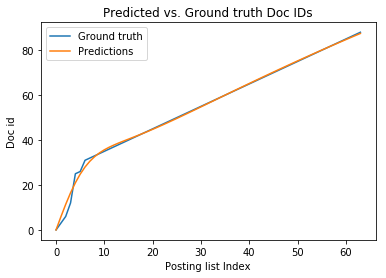

[TERM]: 34110, [TERM_LEN]: 4944, [EPOCH]: 100001, [LOSS]: 1.428472
[TERM]: 34202, [TERM_LEN]: 8921, [EPOCH]: 0, [LOSS]: 467.900463
[TERM]: 34202, [TERM_LEN]: 8921, [EPOCH]: 1000, [LOSS]: 0.142887
[TERM]: 34202, [TERM_LEN]: 8921, [EPOCH]: 2000, [LOSS]: 0.142877
[TERM]: 34202, [TERM_LEN]: 8921, [EPOCH]: 3000, [LOSS]: 0.142845
[TERM]: 34202, [TERM_LEN]: 8921, [EPOCH]: 4000, [LOSS]: 0.143198
[TERM]: 34202, [TERM_LEN]: 8921, [EPOCH]: 5000, [LOSS]: 0.142880
[TERM]: 34202, [TERM_LEN]: 8921, [EPOCH]: 6000, [LOSS]: 0.161848
[TERM]: 34202, [TERM_LEN]: 8921, [EPOCH]: 7000, [LOSS]: 0.143531
[TERM]: 34202, [TERM_LEN]: 8921, [EPOCH]: 8000, [LOSS]: 0.143218
[TERM]: 34202, [TERM_LEN]: 8921, [EPOCH]: 9000, [LOSS]: 0.143066
[TERM]: 34202, [TERM_LEN]: 8921, [EPOCH]: 10000, [LOSS]: 0.142968
[TERM]: 34202, [TERM_LEN]: 8921, [EPOCH]: 11000, [LOSS]: 0.142916
[TERM]: 34202, [TERM_LEN]: 8921, [EPOCH]: 12000, [LOSS]: 0.142928
[TERM]: 34202, [TERM_LEN]: 8921, [EPOCH]: 13000, [LOSS]: 0.143001
[TERM]: 34202, [TERM

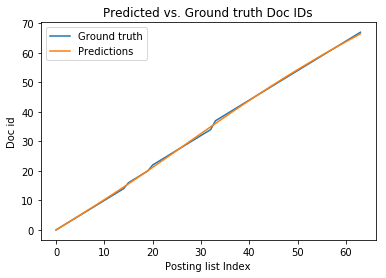

[TERM]: 34202, [TERM_LEN]: 8921, [EPOCH]: 100001, [LOSS]: 0.142854
[TERM]: 39085, [TERM_LEN]: 6140, [EPOCH]: 0, [LOSS]: 261.424787
[TERM]: 39085, [TERM_LEN]: 6140, [EPOCH]: 1000, [LOSS]: 5.596608
[TERM]: 39085, [TERM_LEN]: 6140, [EPOCH]: 2000, [LOSS]: 5.578328
[TERM]: 39085, [TERM_LEN]: 6140, [EPOCH]: 3000, [LOSS]: 5.578690
[TERM]: 39085, [TERM_LEN]: 6140, [EPOCH]: 4000, [LOSS]: 5.579185
[TERM]: 39085, [TERM_LEN]: 6140, [EPOCH]: 5000, [LOSS]: 5.579307
[TERM]: 39085, [TERM_LEN]: 6140, [EPOCH]: 6000, [LOSS]: 5.579030
[TERM]: 39085, [TERM_LEN]: 6140, [EPOCH]: 7000, [LOSS]: 5.578703
[TERM]: 39085, [TERM_LEN]: 6140, [EPOCH]: 8000, [LOSS]: 5.578507
[TERM]: 39085, [TERM_LEN]: 6140, [EPOCH]: 9000, [LOSS]: 5.578431
[TERM]: 39085, [TERM_LEN]: 6140, [EPOCH]: 10000, [LOSS]: 5.578407
[TERM]: 39085, [TERM_LEN]: 6140, [EPOCH]: 11000, [LOSS]: 5.578414
[TERM]: 39085, [TERM_LEN]: 6140, [EPOCH]: 12000, [LOSS]: 5.578416
[TERM]: 39085, [TERM_LEN]: 6140, [EPOCH]: 13000, [LOSS]: 5.578421
[TERM]: 39085, [TERM

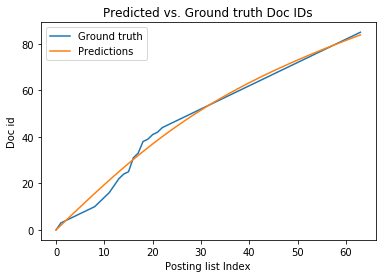

[TERM]: 39085, [TERM_LEN]: 6140, [EPOCH]: 100001, [LOSS]: 5.629466
[TERM]: 39393, [TERM_LEN]: 5758, [EPOCH]: 0, [LOSS]: 52.407389
[TERM]: 39667, [TERM_LEN]: 5407, [EPOCH]: 0, [LOSS]: 50.520778
[TERM]: 41147, [TERM_LEN]: 5821, [EPOCH]: 0, [LOSS]: 200.845116
[TERM]: 44381, [TERM_LEN]: 6537, [EPOCH]: 0, [LOSS]: 35.258099
[TERM]: 48684, [TERM_LEN]: 6399, [EPOCH]: 0, [LOSS]: 85.556690
[TERM]: 51834, [TERM_LEN]: 5114, [EPOCH]: 0, [LOSS]: 6105.510067
[TERM]: 54383, [TERM_LEN]: 4965, [EPOCH]: 0, [LOSS]: 2840.847948
[TERM]: 59451, [TERM_LEN]: 5244, [EPOCH]: 0, [LOSS]: 3054880.059302
[TERM]: 59978, [TERM_LEN]: 8288, [EPOCH]: 0, [LOSS]: 732.477294
[TERM]: 60535, [TERM_LEN]: 5582, [EPOCH]: 0, [LOSS]: 102.424726
[TERM]: 64325, [TERM_LEN]: 4488, [EPOCH]: 0, [LOSS]: 118.132263
[TERM]: 65741, [TERM_LEN]: 4965, [EPOCH]: 0, [LOSS]: 1313.850363
[TERM]: 66945, [TERM_LEN]: 4097, [EPOCH]: 0, [LOSS]: 843.602023
[TERM]: 67486, [TERM_LEN]: 7970, [EPOCH]: 0, [LOSS]: 255.795437
[TERM]: 67594, [TERM_LEN]: 4169, [

In [41]:
import pickle

deltas_list = []
global_max = 0

model = nn.Sequential(
    nn.Linear(1, 3, False),
    nn.Tanh(),
#     nn.BatchNorm1d(3),
    nn.Linear(3, 1, False),
    nn.ReLU()
#             nn.BatchNorm1d(1)
#             nn.Linear(10, 1)
)
model.to(device)

print(model.state_dict())
# Load data
test_collection = Collection("../test_data/test_collection")
for term_id, pl in enumerate(test_collection):
    p = pl[0]
    term_len = len(p)
    if len(p) >= posting_length_to_use:

#         criterion = torch.nn.L1Loss()
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2
#         optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # built-in L2
        
#         lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, verbose=True,
#                                                      threshold=10e-6)

        X = np.arange(term_len).astype(np.double)
        X = torch.arange(term_len, dtype=torch.double).to(device)[0:64].view(-1,1)
        y = p.astype(np.double)
        y -= y[0]
        y = torch.tensor(y, dtype=torch.float64).to(device)[0:64].view(-1,1)
        for t in itertools.count():
            y_pred = model(X)
            loss = criterion(y_pred,y)
            if t % 1000 == 0:
#                 display.clear_output(wait=True)
                print("[TERM]: %i, [TERM_LEN]: %i, [EPOCH]: %i, [LOSS]: %.6f" % (term_id, term_len, t, loss.item()))
            if loss < 0.001 or t > 100000:
                deltas = y_pred.detach().numpy().astype(int) - y.numpy().astype(int)
                delta_zigzag = [len(deltas)] + list(accumulate([zigzag_encode(int(i))+1 for i in deltas]))            
#                 global_max = max(delta_zigzag[-1], global_max)
                deltas_list.append(np.array(delta_zigzag, dtype=np.uint32))
                print(deltas)
#                 print(max(deltas/y))
#                 print(y)
#                 print(y_pred)
                plt.plot(np.arange(y_pred.size(0)), y.cpu().detach().numpy(), label="Ground truth")
                plt.plot(np.arange(y_pred.size(0)), y_pred.cpu().detach().numpy(), label="Predictions")
                plt.xlabel("Posting list Index")
                plt.ylabel("Doc id")
                plt.title("Predicted vs. Ground truth Doc IDs")
                plt.legend(loc="best")
                plt.show()
#             if (loss < 2):
#                 print(y_pred.detach().numpy().astype(int).tolist())
#                 print(y.numpy().astype(int).tolist())
#                 print(np.count_nonzero(deltas))
                print("[TERM]: %i, [TERM_LEN]: %i, [EPOCH]: %i, [LOSS]: %.6f" % (term_id, term_len, t, loss.item()))
#                 deltas+=1
#                 print(list(accumulate([zigzag_encode(int(i)) for i in deltas])))
                break
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
#             if lr_scheduler:
#                 lr_scheduler.step(loss)

            if len(deltas_list) > 10:
                break

            
global_max_list = [1, global_max]            
deltas_array = np.concatenate([np.array(global_max_list, dtype=np.uint32)] + deltas_list).ravel()
DELTA_DIR = os.path.join(BASE_DIR, "../deltas")
delta_file = os.path.join(DELTA_DIR, "{}.docs".format("NN"))
print("Saving deltas to: {}".format(delta_file))
with open(delta_file, "wb") as binfile:
    deltas_array.tofile(binfile)

freqs_file = os.path.join(DELTA_DIR, "{}.freqs".format("NN"))
print("Saving freqs to: {}".format(freqs_file))
with open(freqs_file, "wb") as binfile:
    deltas_array[1:-1].tofile(binfile)


In [ ]:
global_max_list = [1, global_max]            
deltas_array = np.concatenate([np.array(global_max_list, dtype=np.uint32)] + deltas_list).ravel()
DELTA_DIR = os.path.join(BASE_DIR, "../deltas")
delta_file = os.path.join(DELTA_DIR, "{}.docs".format("NN"))
print("Saving deltas to: {}".format(delta_file))
with open(delta_file, "wb") as binfile:
    deltas_array.tofile(binfile)


In [ ]:
freqs_file = os.path.join(DELTA_DIR, "{}.freqs".format("NN"))
print("Saving freqs to: {}".format(freqs_file))
with open(freqs_file, "wb") as binfile:
    deltas_array[1:-1].tofile(binfile)


In [ ]:
orig_list = []
orig_max = 0

for term_id, pl in enumerate(test_collection):
    p = pl[0]
    term_len = len(p)
    if len(p) >= posting_length_to_use:
        orig_max = max(p[-1], orig_max)
        orig_list.append(np.append( np.array([len(p)], dtype=np.uint32),  np.array(p, dtype=np.uint32)))
    if len(orig_list) > 1:
            break

orig_max_list = [1, orig_max]            
orig_array = np.concatenate([np.array(orig_max_list, dtype=np.uint32)] + orig_list).ravel()
DELTA_DIR = os.path.join(BASE_DIR, "../deltas")
orig_file = os.path.join(DELTA_DIR, "{}.docs".format("orig"))
print("Saving orig to: {}".format(orig_file))
with open(orig_file, "wb") as binfile:
    orig_array.tofile(binfile)
